Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Rita González Márquez

Summer term 2024

Name: Stephan Amann, Hannah Blaurock, David Kleindiek

# Neural Data Science Project 02

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

## Question

**Is there spatial structure in the preferred orientation/direction/spatial frequency?**

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
4. Statistical testing. 

It is sufficient to assess spatial structure visually. Bonus points for proper statistical assessment. Also bonus points if you focus on specific cell types.

In [1]:
# import packages here
import utils
from visualization import Visualization as VIS
from ipywidgets import interact, fixed, widgets
from IPython.display import display, Image, clear_output

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import jupyter_black
from tqdm import tqdm

jupyter_black.load()

c:\Users\David\miniforge3\envs\nds\lib\site-packages\oasis\functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


## Context
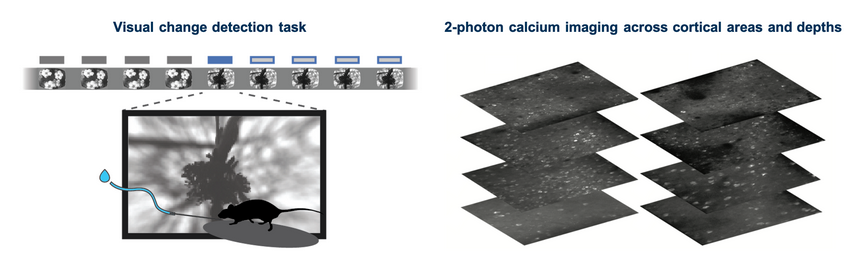

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

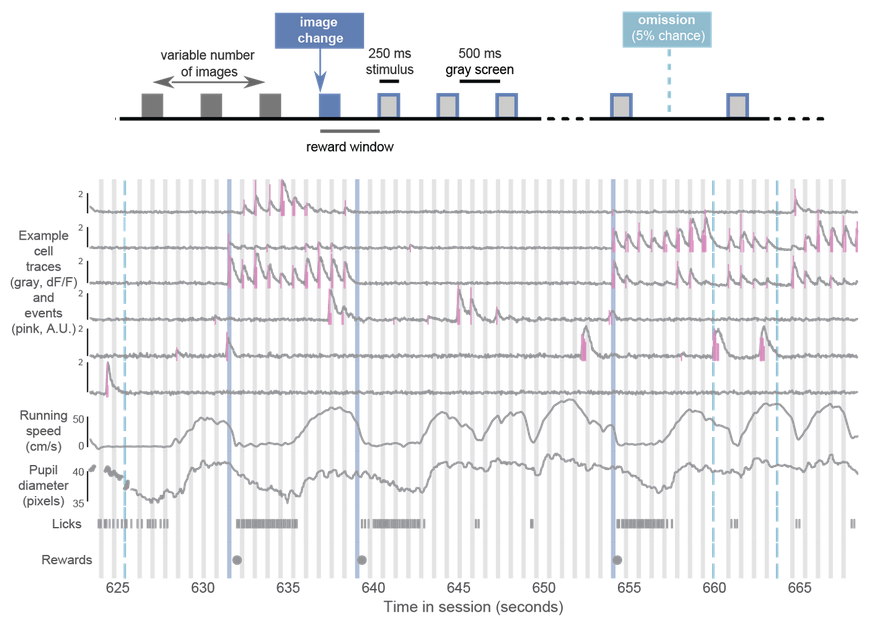

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the ROI masks for each cell
- a maximum activity projection of all ROIs
- running speed
- table of stimulus epochs

You will only work with a drifting grating stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [2]:
# load data
def load_data(path="../data"):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_dsi.npz", allow_pickle=True)
    data = dict(data)
    print("Data keys: ", data.keys())
    array2df(
        data,
        "stim_table",
        ["temporal_frequency", "orientation", "blank_sweep", "start", "end"],
    )
    array2df(data, "stim_epoch_table", ["stimulus", "start", "end"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data()

print("Overview of the data")
print_info(data)

Data keys:  dict_keys(['t', 'dff', 'stim_table', 'roi_masks', 'max_projection', 'running_speed', 'stim_epoch_table'])
Overview of the data
[t] - <class 'numpy.ndarray'>, - (115471,)
[dff] - <class 'numpy.ndarray'>, - (106, 115471)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (628, 5)
[roi_masks] - <class 'numpy.ndarray'>, - (106, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 115471)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



# 1. Exploratory Data Analysis

First we want to take a closer look at the data provided, to understand the experiment conducted. 

In [3]:
# for visualization we use our self-written vis class to avoid clutter in this notebook.
# The data is passed to the class and assigned to variables like in this cell.
vis = VIS(data)

# assign data to variables for easier access
t = data["t"]
dff = data["dff"]
stim_table = data["stim_table"]
roi_masks = data["roi_masks"]
max_projection = data["max_projection"]
running_speed = np.nan_to_num(data["running_speed"][0], nan=0)
stim_epoch_table = data["stim_epoch_table"]

# change stim_table "start" and "end" to int for easier indexing
stim_table["start"] = stim_table["start"].astype(int)
stim_table["end"] = stim_table["end"].astype(int)

# mean time difference in t
t_diff = np.mean(np.diff(t))
print(f"Mean time difference in t: {t_diff} s with sd: {np.std(np.diff(t))} s")

fs = 1 / t_diff  # sampling frequency
dt = 1 / fs  # time step

print(f"Sampling frequency is {fs} Hz, Time Interval is {dt} s")

Mean time difference in t: 0.03325489373863341 s with sd: 4.998870724556607e-06 s
Sampling frequency is 30.070762151865303 Hz, Time Interval is 0.03325489373863341 s


In [4]:
# activity traces of the cells and the running speed of the mouse
interact(
    vis.update_raw_activity_traces_plot,
    cellIdx=vis.cell_index_slider(value=10),
    sample_range=vis.time_interval_slider(value=[1634.0, 1812.0]),
    show_epochs=vis.checkbox(value=True, description="Epochs Stimulus is Shown"),
)

interactive(children=(IntSlider(value=10, continuous_update=False, description='Cell Index:', layout=Layout(wi…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [5]:
# overview on how ofthen a unique stimulus variant is shown to the mouse
print(stim_table.groupby(["orientation", "temporal_frequency"]).size())

# mean duration and standard deviation a gratings stimulus is shown to the mouse
shown_gratings = stim_table[stim_table["blank_sweep"] == 0.0]
mean_time = np.mean(t[shown_gratings["end"]] - t[shown_gratings["start"]])
std_time = np.std(t[shown_gratings["end"]] - t[shown_gratings["start"]])
print(
    f"Mean duration a grating stimulus is shown: {mean_time} s with std: {std_time} s"
)

# some times a blank sweep is shown to the mouse, we can check how often this happens
print("Number of blank sweeps: ", stim_table["blank_sweep"].sum())

orientation  temporal_frequency
0.0          1.0                   15
             2.0                   15
             4.0                   15
             8.0                   15
             15.0                  15
45.0         1.0                   15
             2.0                   15
             4.0                   15
             8.0                   15
             15.0                  15
90.0         1.0                   15
             2.0                   15
             4.0                   15
             8.0                   15
             15.0                  15
135.0        1.0                   15
             2.0                   15
             4.0                   14
             8.0                   15
             15.0                  15
180.0        1.0                   15
             2.0                   15
             4.0                   15
             8.0                   15
             15.0                  15
225.0        1.0  

Note: There is one condition with only 14 instances.

In [6]:
# epochs the grating stimulus is shown to the mouse
stim_epoch_table

,stimulus,start,end
0,drifting_gratings,747,18775
1,natural_movie_three,19709,37767
2,natural_movie_one,38671,47699
3,drifting_gratings,48602,66630
4,spontaneous,66780,75697
5,natural_movie_three,75698,93756
6,drifting_gratings,94659,115215


roi_masks shape:  (106, 512, 512)
roi_masks max:  1


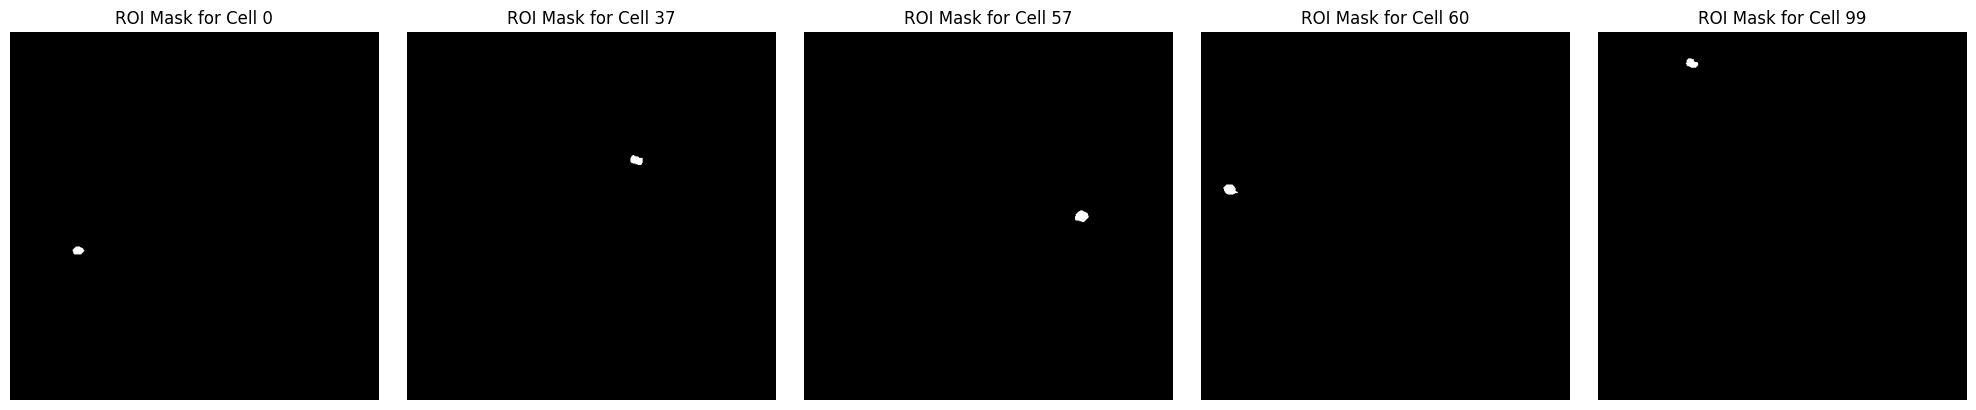

In [7]:
# lets have a look at the ROI masks of the cells
print("roi_masks shape: ", roi_masks.shape)
print("roi_masks max: ", np.max(roi_masks))  # Values are from 0 to 1

# lets plot the masks of some cells
cells = [0, 37, 57, 60, 99]  # TODO select some nice cells
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, cell in enumerate(cells):
    axs[i].imshow(roi_masks[cell], cmap="gray")
    axs[i].set_title(f"ROI Mask for Cell {cell}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()

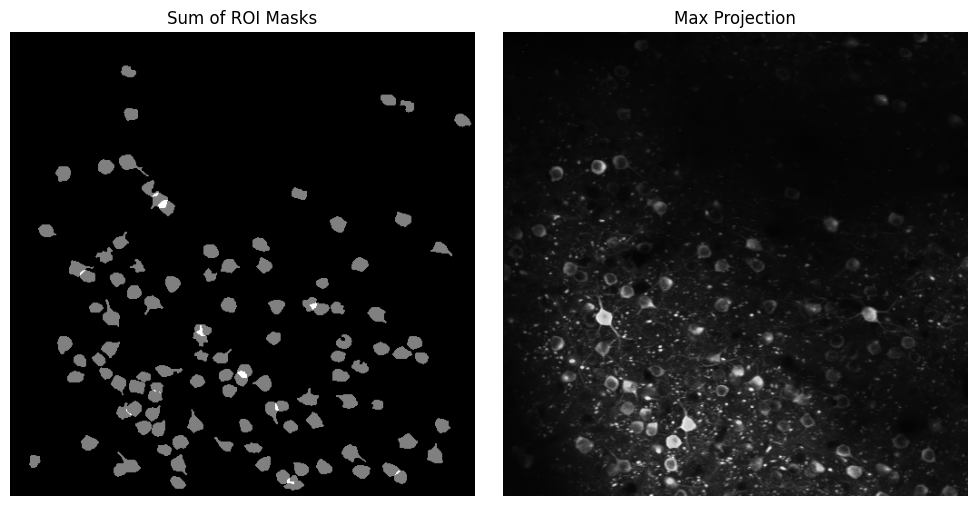

In [8]:
# lets sum up the roi masks to get an overview of the cells and compare it to the max projection
roi_masks_sum = np.sum(roi_masks, axis=0)
roi_masks_sum = roi_masks_sum / np.max(roi_masks_sum)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(roi_masks_sum, cmap="gray")
axs[0].set_title("Sum of ROI Masks")

axs[1].imshow(max_projection, cmap="gray")
axs[1].set_title("Max Projection")

for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()

# 2. Preprocessing

Generally, there are a few algorithms that can lead from a calcium trace signal to a discrete spike train. In the lecture there were several algorithms presented. The paper (ZITATION 1) from the lecture bechnmarks these algorithms. The finding of this study is that the machine learning algorithm implemented show the best results. We implemented this algorithm as well as the OOPSI and OASIS algorithm. The machine learning algorithm (c2s) showed a major underestimation of spikes towards the end. Therefore, even though it showed nice results in the benchmark study, we decided to not follow up on it.

TODO: David/Steph wollen wir den c2s noch einmal hier beispielhaft darstellen bitte?

### 2.1 Process Data with OOPSI

First we decided to process our data with the oopsi alogrithm. This requires filtering. As we learned different filtering techniques in the lecture we adapted them for this project. We implemented a butterworth filter first, as a general bandpass filter. The bandwidth used was a hundretst (low) and a tenth (high) of the sampling frequency of approx. 30 Hz, divided by the half of the sampling frequency. This was a reasonable bandwidth for similar settings. To increase the signal to noise ratio we also implemented a wiener filter. This was also done by the original oopsi authors. The effect of the filters can be assessed with the plots below.

Then we applied the actual oopsi deconvolution. The resulting spike train is shown below in a plot together with the oasis spike trains.

In [9]:
# butterworth filter
low = 0.3 / (fs / 2)
high = 3 / (fs / 2)

# create abs(dff)
# dff_abs[dff_abs < 0] = 0  # = np.abs(dff)
dff_butter = utils.butter_filter_signal(
    x=dff, low=low, high=high, fs=fs, order=4
)  # TODO play with parameters, ich weiß nicht mehr was die bedeuten

# as butterworth filter introduces negative values, we need to set them to zero
# dff_butter[dff_butter < 0] = 0

# wiener filter
window_wiener = 10  # TODO sollten wir hier eine windows size nehmen, die einer spike dauer entspricht?
dff_wiener = utils.wiener_filter_signal(x=dff, window=window_wiener)

# both filters applied sequentially
dff_both = utils.wiener_filter_signal(x=dff_butter, window=window_wiener)

In [10]:
interact(
    vis.update_filter_traces_plot,
    cellIdx=vis.cell_index_slider(value=10),
    sample_range=vis.time_interval_slider(value=[1634.0, 1812.0]),
    dff_butter=fixed(dff_butter),
    dff_wiener=fixed(dff_wiener),
    dff_both=fixed(dff_both),
)

interactive(children=(IntSlider(value=10, continuous_update=False, description='Cell Index:', layout=Layout(wi…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [11]:
# we provide the processed data as a file
oopsi_from_file = False
if not oopsi_from_file:
    oopsi_spikes = utils.oopsi_inference(
        dff=dff_both, dt=dt, thresh=0.035, to_file=True
    )
else:
    oopsi_spikes = utils.load_inferred_spikes("../data/inference_oopsi.pkl")

for k in oopsi_spikes.keys():
    print(f"Key: {k}, Shape: {oopsi_spikes[k].shape}")

Key: spikes, Shape: (106, 115471)
Key: deconv, Shape: (106, 115471)
Key: binspikes, Shape: (106, 115471)


### 2.2 Process Data with OASIS

The OASIS alogrithm also follows a deconvolution approach. 

One of the main aspects in all three algorithms is that you don't get binary spike train, instead the spikes are continous values between 1 and 0. This creates problems when you want to downsample the spikes to the stimulus frequency later on, as you then need a proper spike count. The returned spike train can be fed into the spike count but this leads to an underestimation of the impact of the spikes. Therefore the signal would need to be scaled to account for the underestimation. This leads to the question at which factor the scaling needs to be done. Also, non-binary spike trains make peri stimulus time histograms and visual assessment of the spike trains much harder. In total, a binary spike train makes further analysis easier, even though you lose information about the certainty of the spikes. Since OASIS already implements a threshold approach for assessing wether or not we have an actual spike, the "noisy" spike train from oasis can be directly translated to a binary spike train, which is what we did.

- Thresholding wird auch von https://doi.org/10.1371/journal.pcbi.1005423 durchgeführt, liefert ganz gut Ergebnisse

In [12]:
# this runs for a while. You can load the results from file in the cell below instead.
# If you want to run it, set from_file=False
from_file = False
if not from_file:
    oasis_spikes = utils.oasis_inference(dff=dff, to_file=True)
else:
    oasis_spikes = utils.load_inferred_spikes("../data/inference_oasis.pkl")

for k in oasis_spikes.keys():
    print(f"Key: {k}, Shape: {oasis_spikes[k].shape}")

Key: spikes, Shape: (106, 115471)
Key: deconv, Shape: (106, 115471)
Key: binspikes, Shape: (106, 115471)


In [13]:
interact(
    vis.update_inferred_spikes_plot,
    cellIdx=vis.cell_index_slider(value=10),
    sample_range=vis.time_interval_slider(value=[1634.0, 1812.0]),
    show_oopsi=vis.checkbox(value=True, description="Show OOPSI"),
    show_oasis=vis.checkbox(value=True, description="Show OASIS"),
    oopsi_spikes=fixed(oopsi_spikes),
    oasis_spikes=fixed(oasis_spikes),
    input_trace=fixed(dff_both),  # input data for oopsi (oasis is raw data)
)

interactive(children=(IntSlider(value=10, continuous_update=False, description='Cell Index:', layout=Layout(wi…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

Looking at the default values in the exploratory plot, we can cleraly see a difference between OOPSI and OASIS. Whilst OOPSI often reduces high signals to one spike, OASIS sees recognizes a lot of fast spikes happening. This might be due to a restrictive filtering for OOPSI but could also indicate the better functionality of OASIS. Therefore, and because OASIS requires no filtering and applies direct thresholding, we opted out for OASIS and chose to use the inferred binary spike train from OASIS for the rest of the analysis.

In [14]:
# as we use OASIS spikes, for the following analysis this is referred to as inferred_spikes
inferred_spikes = oasis_spikes
vis.set_inferred_spikes(
    inferred_spikes
)  # set the inferred spikes for the visualization class

### 2.4 Visual Analysis of Filtered Spikes

Explicitly looking at the distribution of spikes for each cell can help to understand how spikes react to the stimuli. To see the reaction to certain combinations of stimuli, we overlayed the spike trains for each distinct stimulus. Stimuli differ in their direction and the temporal frequency at which they are presented. With "Spike Density Function" you can toggle peri-stimlus time histgorams.

In [15]:
interact(
    vis.update_stimulus_spike_times,
    cellIdx=vis.cell_index_slider(value=10),
    frequency=vis.frequency_dropdown(),
    histogram=vis.checkbox(value=False, description="Spike Density Function"),
)

interactive(children=(IntSlider(value=10, continuous_update=False, description='Cell Index:', layout=Layout(wi…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

## 2.4 Intermediate Analysis

### Running Speed
To assess wether running speed has an influence on our firing rate we can visualize the data and look at the correlations of both measurements. One could argue that a higher running speed leads to a higher arousal in of the mouse and therefore to more spontaneous spiking activity. Therefore it is important to consider the effects of running speed on our spike trains.

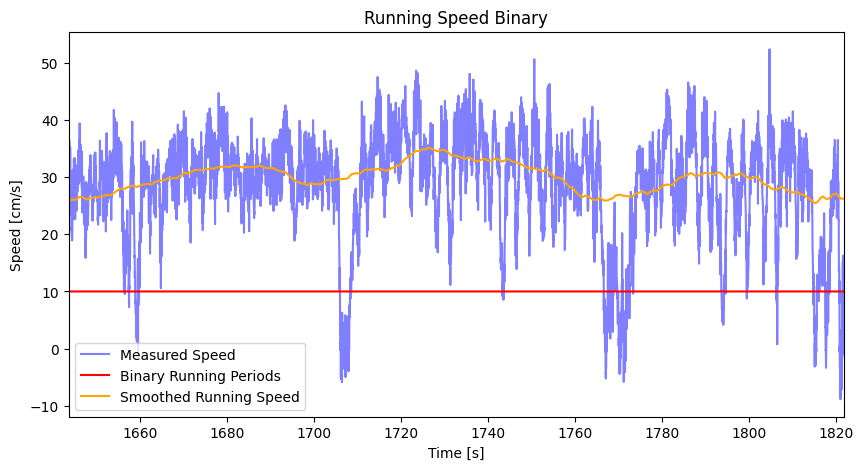

In [16]:
# TODO über den teil müssen wir nichmal schauen!

# we filter the running speed signal
running_periods = utils.filter_running_speed(running_speed)
# convolution und smoothing mit root mean squared error
# Window size: we apply quite heavy smoothing for better visualization --> between 500-1000 is feasible here
running_smooth = utils.window_rms(running_speed, 750)

vis.filtered_running_speed(1634.0, 1812.0, running_periods, running_smooth)

In [17]:
# correlation between running periods and spikes
# assert running_periods.shape[0] == inferred_spikes["binspikes"].shape[1]
# utils.analyze_spike_running_correlation(inferred_spikes["binspikes"], running_periods)

# TODO am ende schauen ob wir das noch wollen

Top 10 cells with highest correlation with running activity:  [ 59  80  67  77   1  98  83 105  86  24]


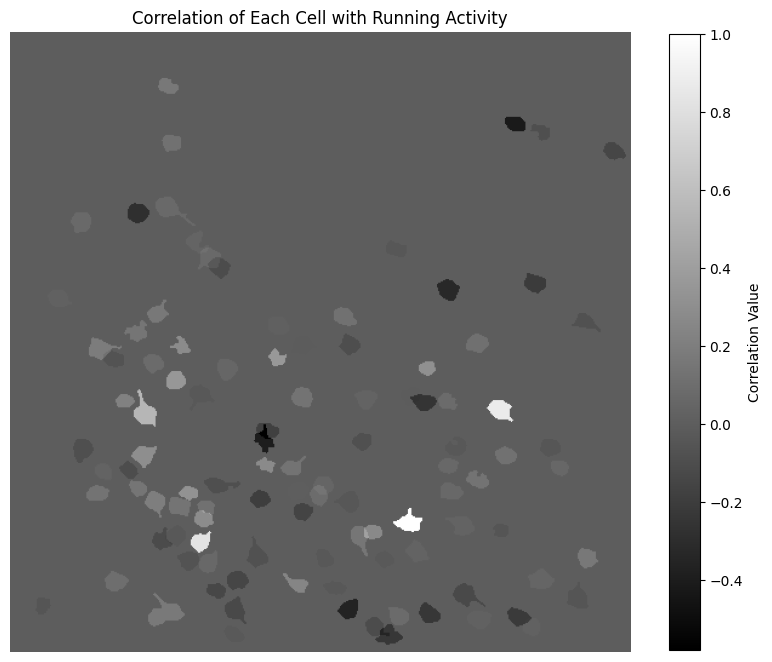

In [18]:
roi_masks_corr_sum, cell_corr, top_10 = utils.get_running_correlation_max(
    roi_masks, inferred_spikes, running_speed
)  # TODO erzählen dass wir hier auch bei smooth keinen effect haben

print("Top 10 cells with highest correlation with running activity: ", top_10)
# print(cell_corr)

# TODO wenn steph noch bock hat, auslagern
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
# axs.imshow(roi_masks_sum, cmap="gray", alpha=0.5)
im = axs.imshow(roi_masks_corr_sum, cmap="gray")
# show color bar
cbar = fig.colorbar(im, ax=axs, shrink=0.8)
cbar.set_label("Correlation Value")

axs.set_title("Correlation of Each Cell with Running Activity")
axs.axis("off")
plt.show()

We can see that, even though some cells clearly have a higher correlation with running speed than others, the overall magnitude of the correlations is rather small. Therefore, as running speed seems to have no major effect on our spiketrains altogether, we can keep the cells with a higher correlation with running speed as potentially more noisy in mind but won't have to take steps to filter out the effects of running speed.

# 3. Tuning Function and Statistical Analysis

- welche Tuning function verwenden wir?
- welchen Test verwenden wir?
- Warum die Auflösung nach Temporal?

## 3.1 Fitting von von Mises Tuning Curve

TODO TEXT

In [19]:
# TODO description
fitted_tuning_curves = utils.fitTemporalTuningCurve(
    inferred_spikes,
    stim_table,
)
# DAVID
# The dictionary contains the fitted tuning curves, mean spike counts and standard deviations for each neuron
# access like this: fitted_tuning_curves[neuron]["fitted_curves"], fitted_tuning_curves[neuron]["mean_spike_counts"], fitted_tuning_curves[neuron]["std_spike_counts"]
# fitted_tuning_curves[0]["fitted_curves"].shape # (n_temporal_frequencies, n_directions)

100%|██████████| 106/106 [00:19<00:00,  5.47it/s]


In [20]:
# TODO description
max_of_temporal_tuning_curve = utils.getMaxOfTemporalTuningCurves(
    fitted_tuning_curves.copy(), stim_table
)
max_of_temporal_tuning_curve[0]

{'max_direction': 90.0, 'max_direction2': 270.0, 'is_orientationnal': 1}

In [21]:
interact(
    vis.update_directional_tuning_curve,
    cellIdx=vis.cell_index_slider(value=10),
    tuning_curve_fit=fixed(fitted_tuning_curves),
)

interactive(children=(IntSlider(value=10, continuous_update=False, description='Cell Index:', layout=Layout(wi…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

## 3.2 Statistical Analysis of the Tuning Curves

TODO Text

In [22]:
# TODO description
# as this functions take a while to compute, we provide the results as a file
from_file = False
if not from_file:
    testTuningFunctionResultsOr, qdistr_Or = utils.testTuningFunction_opt(
        inferred_spikes, stim_table, psi=2
    )
    testTuningFunctionResultsDir, qdistr_Dir = utils.testTuningFunction_opt(
        inferred_spikes, stim_table, psi=1
    )
else:
    testTuningFunctionResultsOr, qdistr_Or = utils.load_tuning_test_results(
        orientation=True
    )
    testTuningFunctionResultsDir, qdistr_Dir = utils.load_tuning_test_results(
        orientation=False
    )
# DAVID
# Return a dictionary with the p-values, q-values and qdistr for each neuron and temporal frequency
# Access like this: testTuningFunctionResults[neuron][temporal_frequency]["p"], testTuningFunctionResults[neuron][temporal_frequency]["q"], testTuningFunctionResults[neuron][temporal_frequency]["qdistr"]
# temporal_frequency = -1 means all directions
testTuningFunctionResultsOr[0].keys()

dict_keys([1, 2, 4, 8, 15, -1])

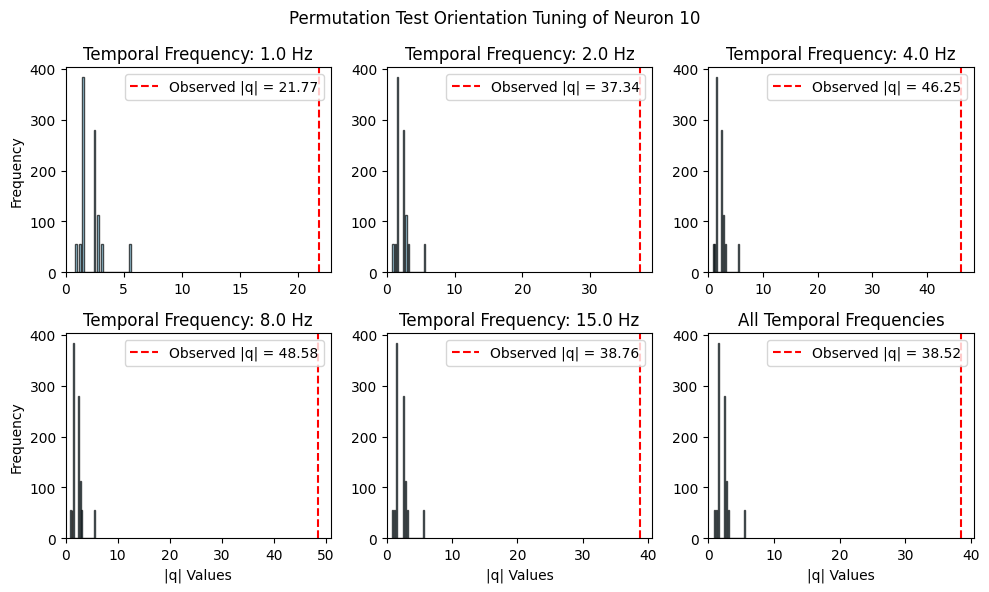

In [23]:
vis.plot_tuning_orientation_test(10, testTuningFunctionResultsOr, qdistr_Or)

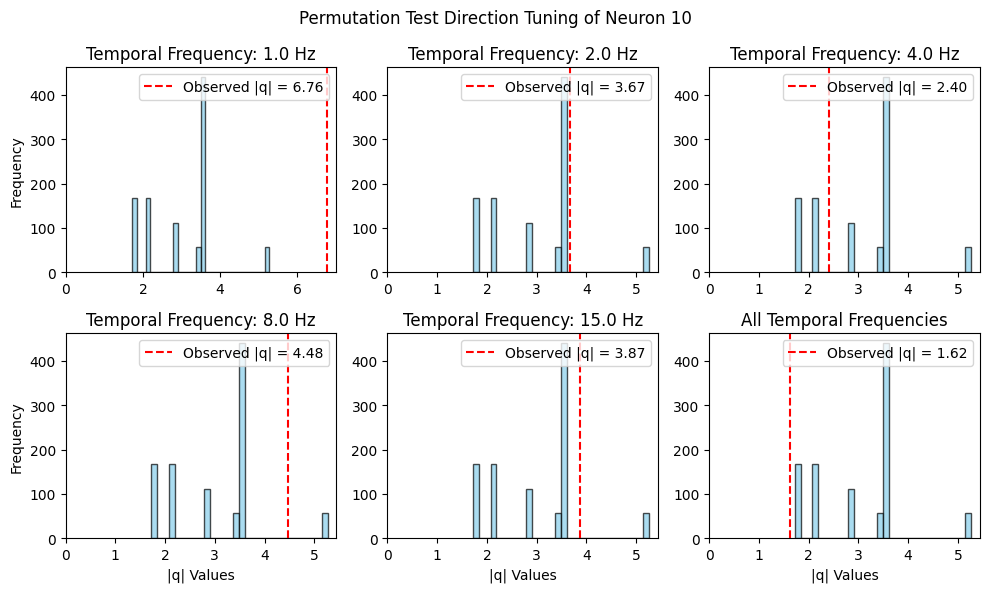

In [24]:
# TODO description
vis.plot_tuning_orientation_test(
    10, testTuningFunctionResultsDir, qdistr_Dir, direction=True
)

### 

In [25]:
temporal_tunings = utils.getTemporalTunings(inferred_spikes, stim_table)

interact(
    vis.update_temporal_tuning_curve,
    cellIdx=vis.cell_index_slider(value=10),
    temporal_tunings=fixed(temporal_tunings),
)

interactive(children=(IntSlider(value=10, continuous_update=False, description='Cell Index:', layout=Layout(wi…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [26]:
import importlib

importlib.reload(utils)

<module 'utils' from 'c:\\Users\\David\\projects\\uni-tue-nds\\Project\\notebooks\\utils.py'>

In [27]:
from joblib import Parallel, delayed
import pickle

# import f_oneway
from scipy.stats import f_oneway


def get_p_values_permutation_test(
    inferred_spikes, stim_table, n_permutations, load_from_file=False
):
    if load_from_file:
        neuron_stats, permuted_stats, p_values = pickle.load(
            open("../data/p_values_permutation_test.pkl", "rb")
        )
        return neuron_stats, permuted_stats, p_values
    else:
        neuron_stats, permuted_stats = utils.get_p_values_permutation_test_helper(
            inferred_spikes, stim_table, n_permutations
        )
        p_values = np.array(
            [
                np.mean(permuted_stats[neuron] >= neuron_stats[neuron])
                for neuron in range(inferred_spikes["binspikes"].shape[0])
            ]
        )
        pickle.dump(
            (neuron_stats, permuted_stats, p_values),
            open("../data/p_values_permutation_test.pkl", "wb"),
        )
        return neuron_stats, permuted_stats, p_values


load_from_file = False
neuron_stats, permuted_stats, p_values = get_p_values_permutation_test(
    inferred_spikes, stim_table, 10, load_from_file
)

In [28]:
inferred_spikes

{'spikes': array([[0.00000000e+00, 0.00000000e+00, 1.73387859e-02, ...,
         0.00000000e+00, 0.00000000e+00, 2.55226378e-01],
        [0.00000000e+00, 0.00000000e+00, 1.68206696e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 1.46887095e-01, 0.00000000e+00],
        ...,
        [0.00000000e+00, 2.14291317e-04, 2.61679722e-02, ...,
         0.00000000e+00, 1.76353151e-01, 1.55259356e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 7.48470312e-02, 5.58922526e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
 'deconv': array([[0.08095306, 0.07234861, 0.08199751, ..., 0.14542874, 0.12997122,
         0.37138304],
        [0.15972583, 0.12415276, 0.11332296, ..., 0.        , 0.        ,
         0.        ],
        [0.21571498, 0.19463631, 0.17561735, ..., 0.1

In [29]:
np.where(p_values < 0.001)

(array([  2,   5,   6,   7,   9,  10,  12,  14,  16,  17,  18,  19,  20,
         21,  23,  25,  26,  27,  28,  29,  31,  32,  34,  35,  37,  41,
         42,  43,  45,  46,  48,  49,  50,  51,  52,  53,  54,  55,  60,
         64,  66,  68,  69,  70,  71,  75,  77,  78,  80,  82,  84,  88,
         90,  93,  95,  99, 101, 102, 104, 105], dtype=int64),)

### 3.3 Asessment of dependency of Temporal Frequency

To assess wether some Neurons tend to have an increased firing rate at certain temporal frequencies we plot the mean firing rate of each Neuron at each Temporal frequency. As we don't want to be able to model these firing rates it is sufficient to assess wether or not there is a significant effect of the Temporal Frequencies or not. This can be done via a non-parametric permutation test. For each Neuron we compute the difference in variance explained by the temporal frequency (with a oneway ANOVA) and compare it with 1000 permuted samples.

We can see that the firing rate of quite a few cells is dependent on the Temporal Frequency at which the stimulus is presented. 

### 3.4 Complex vs Simple Cells:

Dividing Simples Cells and Complex Cells by the f1/f0 ratio (linearity index) is a well known procedure, first noted by Hubel and Wiesel (1962; Journal of Physiology, London, 160, 106–154). Because it has been verifyed many times we use the same ratio to classify simple and complex cells. In the lecture we learned that complex and simple cells are senstive to the orientation of a stimulus, but only simple cells are sensitive to the direction (the phase) of the stimulus. Therefore instead of computing the f1 component seperately, we can simply use the the fourier components already extracted whilst performing our Permutation Tests. In the Permutation Tests we compute $v_k = \exp(\psi i \theta_k)$, where $\theta_k$ is the $k$-th direction of motion in radians and $\psi \in 1,2$ is the fourier component to test (1: direction, 2: orientation). The magnitude $|q|$ tells us how much power there is in the $\psi$-th fourier component. (Credit to CL4)
If we set $\psi$ to 1 in that we extract the magnitude (amplitude) of the first fourier component (f1). This can be used to calculate the ratio to decide wether a cell is simple or complex.
f0 can simply be described by the mean spike count binned by stimulus duration (0.5 Hz). 
In total we can say that if $ \frac{f1}{f0} < 1$  we have a complex cell, and if $\frac{f1}{f0} > 1$ we have a simple cell. Because the cell should be invariant to direction tuning at all temporal frequencies, but we get heavily different values for direction tuning depending on the temporal frequency, we assess wether a cell is complex or not by computing a linearity index for all temporal frequencies. If all of those are smaller than 1, we can safely say that we have a complex cell at our hands.

In [30]:
# Old computation of the linearity index
from scipy.fft import fft

stimulus_frequency = 0.5  # 1 stimulus every 2s
neurons = inferred_spikes["binspikes"].shape[0]
spike_count = np.zeros((neurons, stim_table["orientation"].shape[0]))
p_direction = np.zeros(neurons)
f1_comp = np.zeros(neurons)
for neuron in range(neurons):
    counts = utils.bin_spike_counts(stim_table, inferred_spikes, neuron=neuron)
    spike_count[neuron, :] = counts
    # Compute FFT of the spike counts
    fft_result = fft(counts)
    freqs = np.fft.fftfreq(len(counts), d=(1.0 / stimulus_frequency))
    # Magnitude of DC component
    f0 = np.mean(counts)
    # Find the index of the frequency closest to the stimulus frequency
    f1_index = np.argmin(
        np.abs(
            freqs - stimulus_frequency
        )  # find index of the frequency that is closest to stimulus frequency
    )  # fundamental frequency, f1 is the LOWEST POSSIBLE frequency of vibration in the system.
    #  The F1 values reported here are the magnitudes of the first component (at stimulus temporal frequency) of the frequency spectra
    # Compute the magnitude (amplitude) of the first harmonic component (F1)
    f1 = np.abs(fft_result[f1_index])
    f1_comp[neuron] = f1 / f0

C:\Users\David\AppData\Local\Temp\ipykernel_30496\3973361070.py:26: RuntimeWarning: invalid value encountered in scalar divide
  f1_comp[neuron] = f1 / f0


In [31]:
stim_table

,temporal_frequency,orientation,blank_sweep,start,end
0,1.0,225.0,0.0,747,807
1,2.0,180.0,0.0,837,897
2,4.0,90.0,0.0,927,987
3,1.0,270.0,0.0,1018,1077
4,4.0,135.0,0.0,1108,1168
...,...,...,...,...,...
623,4.0,315.0,0.0,114794,114854
624,2.0,45.0,0.0,114884,114944
625,4.0,180.0,0.0,114975,115034
626,4.0,270.0,0.0,115065,115125


In [32]:
# spike_count2 = [utils.bin_spike_counts(stim_table, inferred_spikes, neuron=neuron) for neuron in range(neurons)]
keys_dict = {1: "1", 2: "2", 4: "4", 8: "8", 15: "15", -1: "-1"}
p_thresh = 0.0001

df_dir = utils.process_tuning_results(
    testTuningFunctionResultsDir,
    stim_table,
    inferred_spikes,
    max_of_temporal_tuning_curve,
    list(keys_dict.keys()),
    p_thresh,
)
df_or, df_complex, df_non_complex, comp_or, noncomp_or, comp_dir, noncomp_dir = (
    utils.process_tuning_data(
        testTuningFunctionResultsOr,
        max_of_temporal_tuning_curve,
        df_dir,
        list(keys_dict.values()),
    )
)

### Assessment of the Distribution of p Values

Note: All Conlusion are made at a significance level of p = 0.0001. Since we make the conclusion at this significance level, all p value are treated as binary values (either the neuron is significant for this condition or it isn't). We chose this resctrictive significance level because we were very liberal with our spike threshold, as described above.

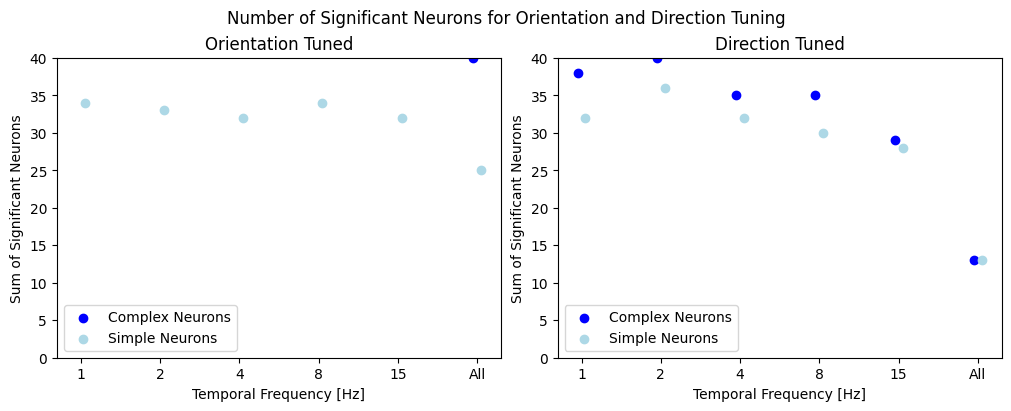

In [33]:
vis.plot_num_significant_cells(comp_or, noncomp_or, comp_dir, noncomp_dir)

Overall, there are way less Neurons significantly tuned for direction than there are tuned for orientation. 

This Plot shows a clear interaction between Direction Tuned Neurons and the Temporal Frequency of the Stimulus presented. There are 2 Neurons tuned for direction invariant of the temporal frequency (one simple and one complex). But there are many more Neurons that are tuned for direction dependent on a certain temporal frequency. Therefore we can say that the directional tuning component is always dependent on some temporal frequency at which the stimulus is presented, and the neurons react specifically to the combination of the direction and the temporal frequency. 

There seems to be no interaction between the temporal component and the orientation. There are equally many Neurons sensitive to an orientation at a specific temporal frequency than there are at all temporal frequencies. It seems that the temporal component doesn't affect the neurons preferred orientation - the neuron prefers the orientation (aka is tuned to it) regardless of the temporal frequency at which it is presented. 
This is good because it implies a sanity check of our data - if it were dependent on the temporal frequency, the orientation component would not simply take orientation but are more complex structure into account.  

Surprising is the fact that there are equally as many complex cells as there are simple cells that are tuned for direction. This should not be the case, as the linearity index (f1/f0) ratio should ensure that only Neurons that are invariant of to the phase of the grating, meaning invariant to direction and temporal frequency, of the stimulus are considered complex. This implies that either there is a lot of random noise in our data and the curves are falsely fitted to the direction. Or it implies that the f1/f0 ratio is either not correctly implemented or not conservative enough to account for random noise in our spike trains.


In [34]:
utils.kolomogrovTest(df_or)
utils.kolomogrovTest(df_dir)
utils.kolomogrovTest(df_or, df_dir)

----------------------------------------------------
Significance Testing for Orientational Tuned Neurons
----------------------------------------------------
  Base Distribution Compared Distribution  KS Statistic   P-value
0          all_freq                  1_hz      0.122642  0.404240
1          all_freq                  2_hz      0.150943  0.179002
2          all_freq                  4_hz      0.150943  0.179002
3          all_freq                  8_hz      0.150943  0.179002
4          all_freq                 15_hz      0.113208  0.507365
----------------------------------------------------
----------------------------------------------------
Significance Testing for Orientational Tuned Neurons
----------------------------------------------------
  Base Distribution Compared Distribution  KS Statistic       P-value
0          all_freq                  1_hz      0.415094  1.461578e-08
1          all_freq                  2_hz      0.471698  4.947214e-11
2          all_freq    

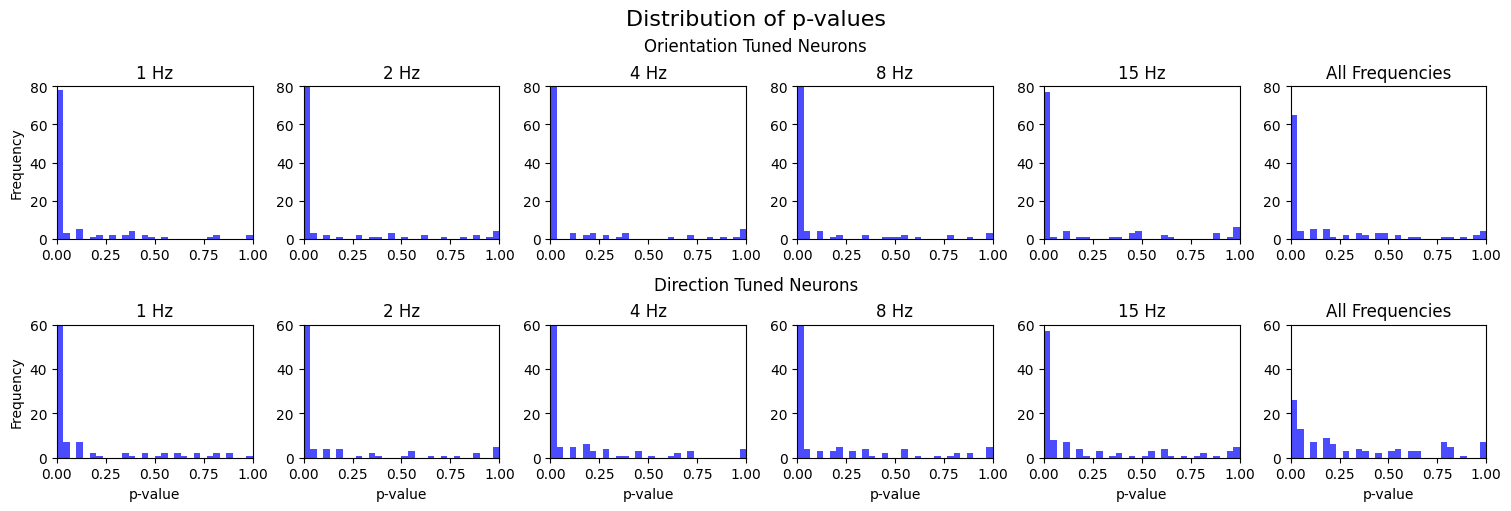

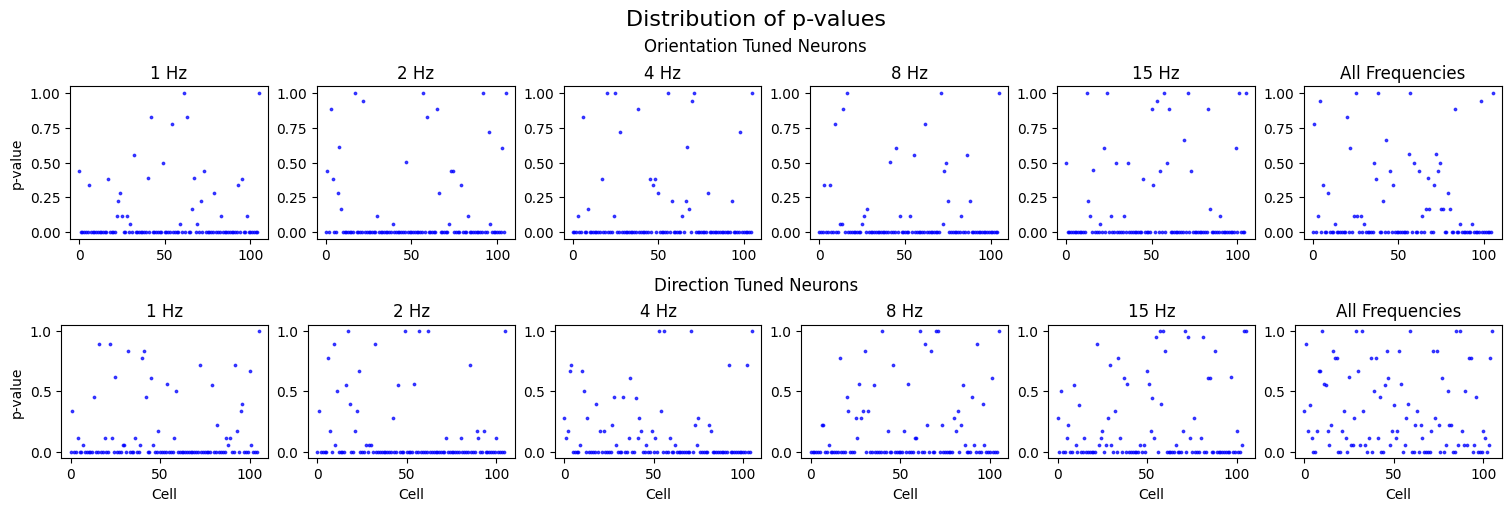

In [35]:
# TODO @Hannah, du kannst entscheiden ob du das drin haben willst
vis.plot_p_distribution(df_or, df_dir, hist=True)
vis.plot_p_distribution(df_or, df_dir, hist=False)

Looking at the Kolmogorov-Smirnov Staistic to assess the statistical difference between the two p distributions. The findings are in line with what we could infer visually from the plot above. There is a significant difference between the directional tuning of all_freq and each of the temporal frequency distributions. This indicates, as described above, an interaction effect between directional tuning and temporal frequency which in turn means that neurons are sensitive to spatial frequency (a specific combination of temporal frequncy and direction).

Also we can see that the distributions of orientational and directional preference are not from the same source, since the statistic is significant, which is more of a sanity check for our data and doesn't really add new information. But it's nice to see that it checks out. 

### Spatial Structure of Tuning

Note: The task was to asses the spatial structure of orientation and direction tuned neurons and the spatial structure of the spatial frequency tuning. Since we have a direction and the temporal frequency given, we can infer the spatial frequency by combining these two information. This is done in the Direction Tuning part of the Conclusion, although it is not mentioned explicitly that we refer to spatial frequency when we discuss the interaction between direction and temporal frequency.

#### Spatial structure of simple and complex cells
We can see no explicit spatial structure in the distribution of simple and complex cells. There seems to be some structure in the lower half of the ROI mask, there seem to be two bulks of complex cells and one bulk of simple cells. Overall the random distribution makes sense from a biological point of view, as usually simple cells are wired to one or more different complex cells. Therefore it makes sense that neither of the cell types is completely distributed to one side / half of our region of interest.

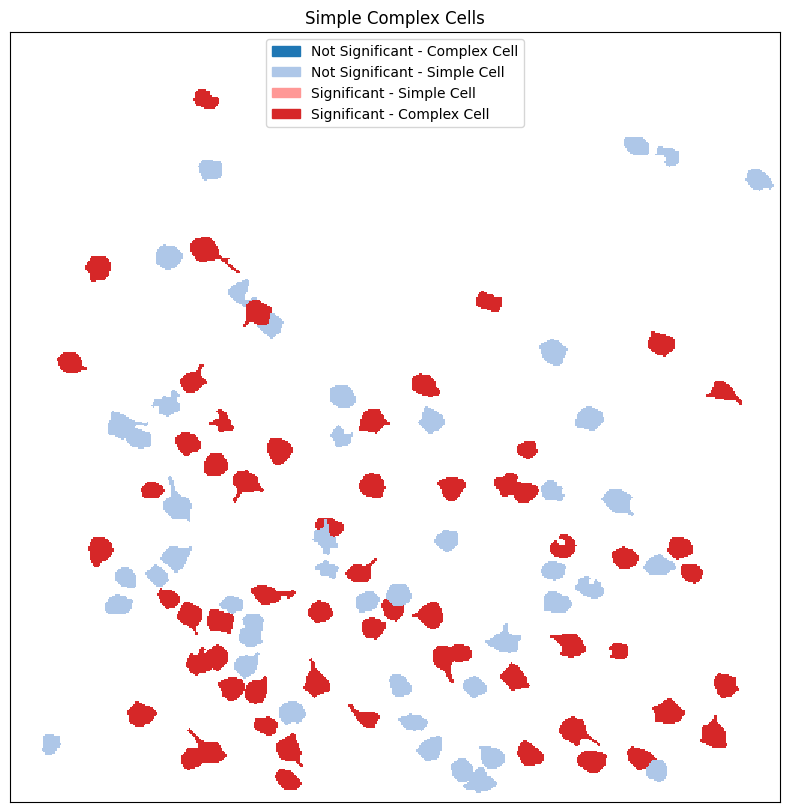

In [36]:
# Use cool visualization by Stephan to display the distribution of simple and complex cells
data = np.zeros((2, len(df_dir["2"].values)))
data[0, :] = (df_dir["complex_flag"].values).astype(int)
data[1, :] = (df_dir["complex_flag"].values).astype(int)
vis.color_roi(data, "Simple Complex Cells", is_binary=True)

#### Spatial Structure of the Direction Tuning

Since we see a clear interaction for Temporal Frequeny and Direction Tuning, we have to look at the individual temporal frequencies. We can only see a structure in the cells for a Temporal Frequeny of 2 Hz, for which we have the most significant Direction Tuned Neurons. The spatial structure of significantly Direction Tuned Neurons for all other Temporal Frequencies seems to be randomly distributed.
For Temporal Frequency 2 Hz we can see an increase of significant Neurons in the upper left and lower middle to right areas of our region of interest. Interestingly, the Neurons in the upper left corner are not significantly tuned for any of the other frequencies. 
If we take a closer look at which Neurons are significant for which temporal frequencies, we can see that there are some neurons that only react to the direction at one specific temporal frequency. This means that some of the Neurons that are tuned to movement are tuned to movement at a specific frequency. Clusters of these Neurons may arise due to coherent firing rates, i.e. the neurons fire at the same frequency and therefore more likely form a cluster.

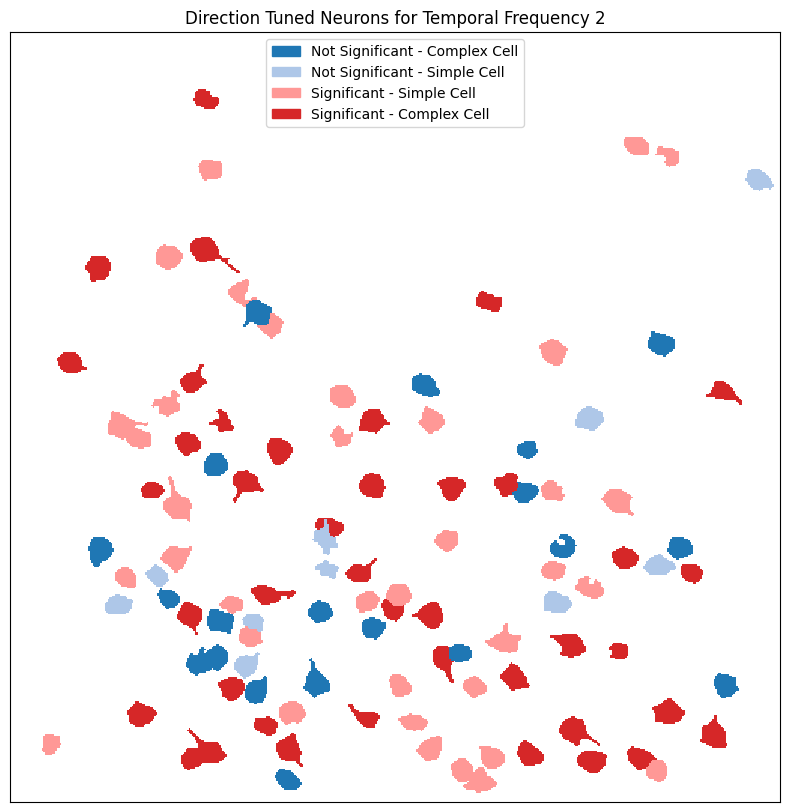

In [37]:
data = np.zeros((2, len(df_dir["2"].values)))
data[0, :] = (df_dir["2"].values).astype(int)
data[1, :] = (df_dir["complex_flag"].values).astype(int)
vis.color_roi(data, "Direction Tuned Neurons for Temporal Frequency 2", is_binary=True)

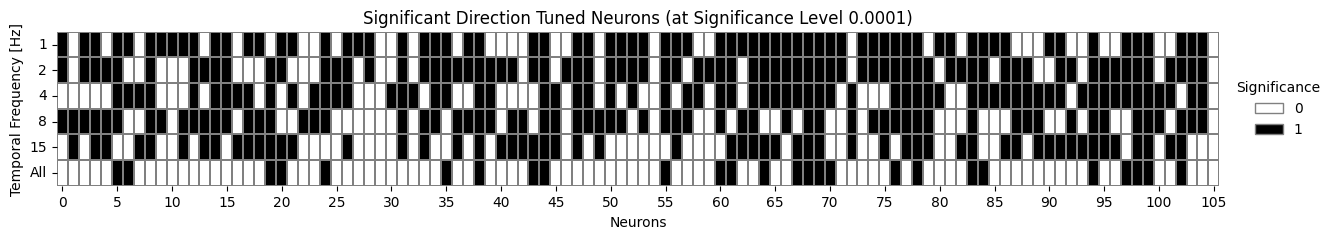

In [38]:
vis.plot_significance_heatmap(df_dir, p_thresh, direction=True)

#### Spatial structure of Orientation Tuned Neurons

As we can see, and as it makes sense, there is not interaction between the temporal frequency of which a stimulus is preferred at and the preferred orientation of that stimulus. 

Overall, we can see little to no spatial structure in the distribution of orientation tuned neurons. What we would expect, or like, to see is that orientation tuned simple cells are clos to orientation tuned complex cells - indicating that they might pass on information to the complex cell. We can see that in four instances. In one instance these cells also have the same preferred orientation. 

We can also see that in some cases, though not in all cases, cells that are close to eachother are both significant or not significant. This either indicates that the cells were falsely separated, that they recieve stimulation by the other cell or that they actually have the same preferences. Deciding this would require further analysis.

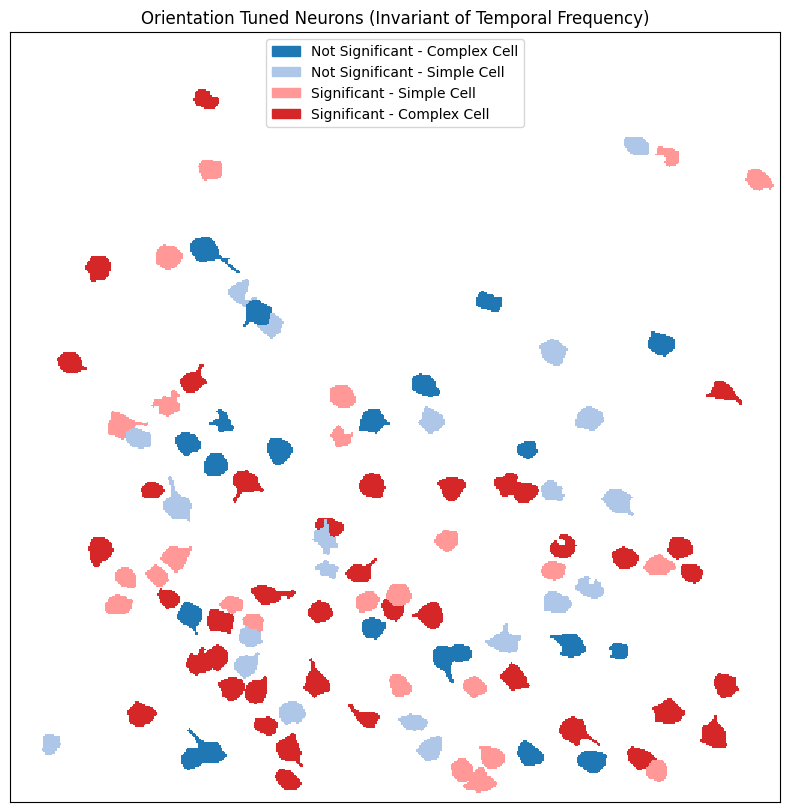

In [39]:
data = np.zeros((2, len(df_or["-1"].values)))
data[0, :] = (df_or["-1"].values).astype(int)
data[1, :] = (df_or["complex"].values).astype(int)
vis.color_roi(
    data, "Orientation Tuned Neurons (Invariant of Temporal Frequency)", is_binary=True
)

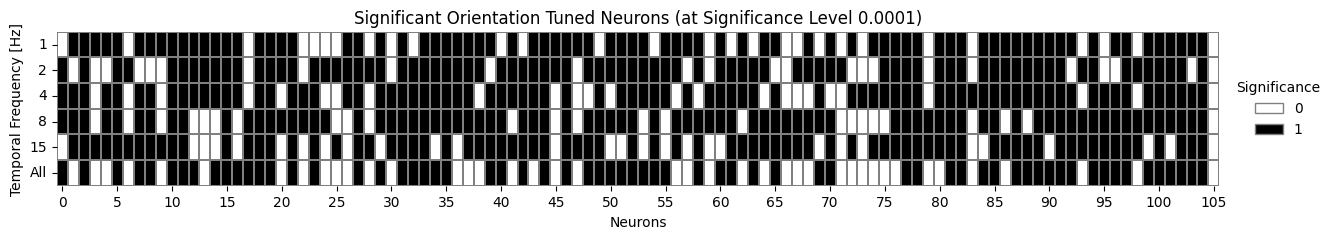

In [40]:
vis.plot_significance_heatmap(df_or, p_thresh, direction=False)

Interestingly in the plot above we can see that most neurons are significant more than once in the different temporal frequencies for the orientation tuning. This further emphasizes that these neurons are invariant to the temporal frequency at which the stimuli are presented. There are also many neurons that are significant in all of the temporal frequency conditions.  

#### Spatial Structure of the preferred Direction of each Neuron

We further investigated the spatial structure of the preferred direction/ orientation of each neuron by extracting the two max peak values from each tuning function. Then only direction (or orientation) sensitive (meaning significant) neurons are plotted. The Directions are color paired, if the directions are opposing they have the same base color. 

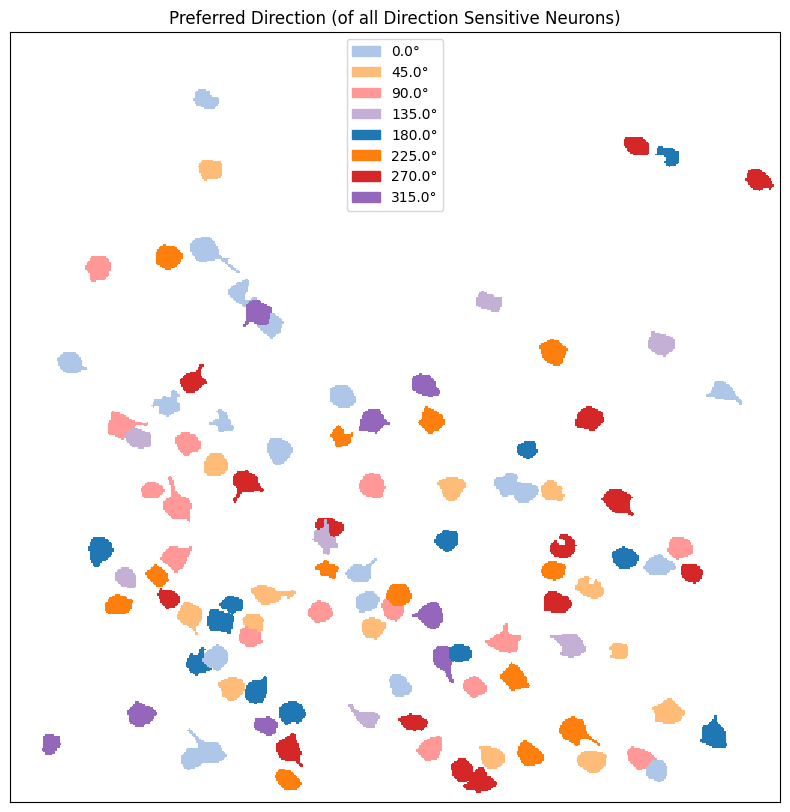

In [41]:
keys_str = list(keys_dict.values())
sig_dir = [
    row["max_direction"] if (row[keys_str] == 1).any() else -1
    for index, row in df_dir.iterrows()
]
vis.color_roi(
    sig_dir,
    "Preferred Direction (of all Direction Sensitive Neurons)",
    is_binary=False,
)

We can see a tendency that Neurons that prefer the same direction are located in pairs, i.e. if on Neuron prefers 90° there is likely another Neuron very close to it that also prefers 90°. But this is a subjective assessment with no statistical backup.

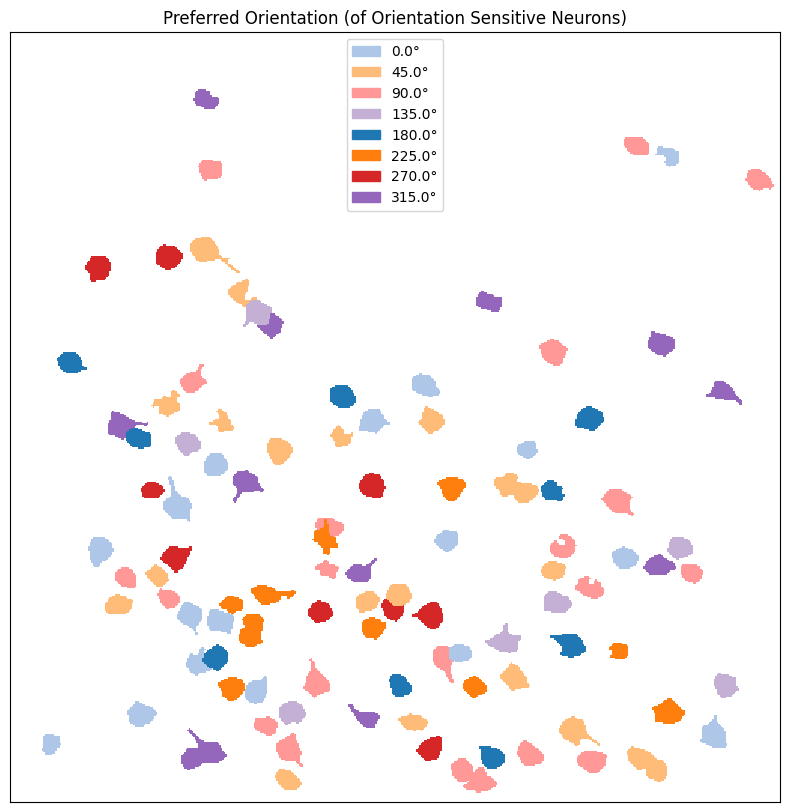

In [42]:
sig_or = [
    row["max_direction2"] if (row[keys_str] == 1).any() else -1
    for index, row in df_or.iterrows()
]
vis.color_roi(
    sig_or,
    "Preferred Orientation (of Orientation Sensitive Neurons)",
    is_binary=False,
)

Since this plot shows Neurons sensitive to orientation, opposing directions should be considered equal. This is also why we extracted the second max peak - if these Neurons are senstive to orientation, both peaks should be at opposing directions. 

# Conclusion

Overall the most interesting finding is the interaction effect between preferred direction and temporal frequency. We can also see that the tuning for orientation and direction generally checks out. There are many orientation tuned neurons that are significant and also have a nice tuning curve function fit, as you would expect it from a modelling point of view.

The main surprising finding is that there seems to be complex cells that are not invariant of the phase of the stimulus presented. This either indicates a faulty implementation, noisy data or is a new finding. Further investigation is needed to assess the cause of this unexpected result.

Also one could consider doing a statistical assessment of the spatial structure of the data to verify the tendcies we discussed above.

In conclusion this was a brief analysis of spike train data, but there might be more information conveyed in the data that is yet to be discovered.